In [88]:
from datetime import datetime 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import io
import requests 
import numpy as np
import warnings #ignore the warnings 
warnings.filterwarnings("ignore")

In [89]:
data = pd.read_csv('AirPassengers.csv')

In [90]:
data.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [91]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [92]:
data.Month = pd.to_datetime(data.Month, format = "%Y-%m-%d")
data.index = data.Month

In [93]:
data.drop('Month', axis = 1, inplace=True)

In [94]:
data

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


<AxesSubplot:xlabel='Month'>

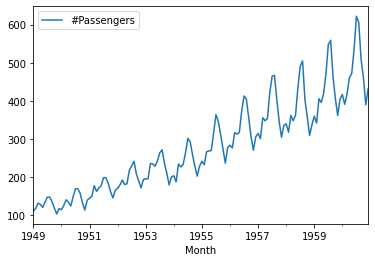

In [95]:
data.plot()

## 1. Data types of time series 

#### We have 2 major types: <br>
    - Stationary: A dataset should follow the below thumb rules without having Trend, Seasonality, Cyclical and Irregularity components of the time series. <br>
        + The constant of mean value <br>
        + The constant of variance <br>
        + Covariance: measure the relationshop between two variables <br>
    - Non-Stationary: mean-variance or covariance is changing with respect to time <br>

#### Check Stationarity: statistical Tests  <br>
    - Augmented Dickey-Fuller (ADF) test 
    
Null Hypothesis (H0): Series is non-stationary
Alternate Hypothesis (HA): Series is stationary
p-value >0.05 Fail to reject (H0)
p-value <= 0.05 Accept (H1)

    - Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test 
Null Hypothesis: The process is trend stationary.

Alternate Hypothesis: The series has a unit root (series is not stationary).


In [96]:
from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries):
    dftest = adfuller(timeseries, autolag = 'AIC')
    dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value 
    print(dfoutput)

In [97]:
adf_test(data['#Passengers'])

Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


P_value >0.05, fail to reject H0, series is non-stationary Alternate Hypothesis (HA)

In [98]:
#define function for kpss test
from statsmodels.tsa.stattools import kpss
#define KPSS
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)
kpss_test(data['#Passengers'])

Results of KPSS Test:
Test Statistic           1.651312
p-value                  0.010000
Lags Used                8.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


In [99]:
kpss_test(data['#Passengers'])

Results of KPSS Test:
Test Statistic           1.651312
p-value                  0.010000
Lags Used                8.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


p_value <0.05, accept H1, series is non-stationary 

## 2. Types of Stationarity

If one of the test showed that the series is stationary while the other showed that the series is not, what would we do?<br>
Actually, there are more one type of stationarity. <br>
- Strict Stationary
- Trend Stationary
- Difference Stationary 

## 3. Converting Non-Stationary Into Stationary

Methods for conversion - detrending, differencing and transformation 
1. Detrending <br>
- It involves removing the trend effects from the given dataset and showing only the differences in values from the trend. It always allows cyclical patterns to be identified. <br>
2. Differencing <br>
3. Transformation <br> 
3 different methods: Power Transform, Square Root, Log Transfer <br>

### 3.1. Differencing
Calculating the difference between consecutive values. Differencing is typically performed to get rid of the varying mean

<AxesSubplot:xlabel='Month'>

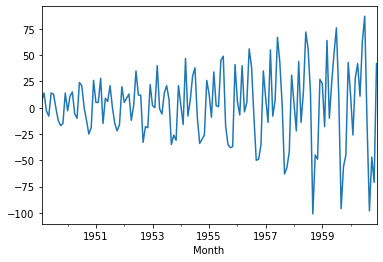

In [100]:
data['Passengers_diff'] = data['#Passengers'] - data['#Passengers'].shift(1)
data['Passengers_diff'].dropna().plot()

In [101]:
adf_test(data['Passengers_diff'].dropna())

Test Statistic                  -2.829267
p-value                          0.054213
#Lags Used                      12.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [102]:
kpss_test(data['Passengers_diff'].dropna())

Results of KPSS Test:
Test Statistic           0.023898
p-value                  0.100000
Lags Used                7.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


In [103]:
#Stationarity 

### 3.2. Seasonal Differencing

Calculate the difference between an observation and a previous observation from the same season

<AxesSubplot:xlabel='Month'>

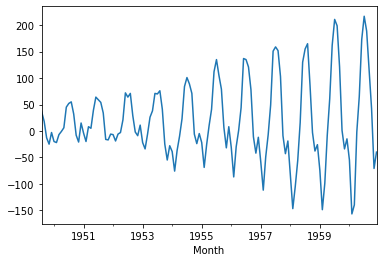

In [104]:
data['Passengers_diff_7day'] = data['#Passengers'] - data['#Passengers'].shift(7)
data['Passengers_diff_7day'].dropna().plot()

In [105]:
adf_test(data['Passengers_diff_7day'].dropna())

Test Statistic                  -3.380110
p-value                          0.011656
#Lags Used                      13.000000
Number of Observations Used    123.000000
Critical Value (1%)             -3.484667
Critical Value (5%)             -2.885340
Critical Value (10%)            -2.579463
dtype: float64


=> The time series after apply seasonal differencing had became stationarity

### 3.3. Transformation

log transform and differencing on our air passenger dataset

<AxesSubplot:xlabel='Month'>

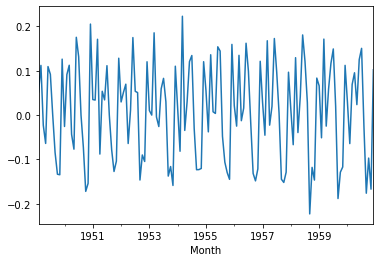

In [106]:
data['#Passengers_log'] = np.log(data['#Passengers'])
data['#Passengers_log_diff'] = data['#Passengers_log'] - data['#Passengers_log'].shift(1)
data['#Passengers_log_diff'].dropna().plot()


In [107]:
adf_test(data['#Passengers_log'].dropna())

Test Statistic                  -1.717017
p-value                          0.422367
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


=> Log Transform chưa đủ mạnh để chuyển dữ liệu về dạng stationarity

In [108]:
adf_test(data['#Passengers_log_diff'].dropna())

Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


### Prepare data to compare
In this part, We create 3 datasets (train and test) to compare the accuracy: <br>
    - Data before transform <br>
    - Data after applying differencing <br>
    - Data after applying log transform and differencing <br>

In [109]:
#Data before transform
data_train = data['#Passengers']['1949-01-01':'1957-12-01'].to_frame()
data_test = data['#Passengers']['1958-01-01': '1960-12-01'].to_frame()

In [124]:
#Data after apply differencing
data_train_difference = data['Passengers_diff']['1949-01-01':'1957-12-01'].to_frame()
data_test_difference = data['Passengers_diff']['1958-01-01': '1960-12-01'].to_frame()

In [126]:
#Data after apply log transform
data_train_log = data['#Passengers_log_diff']['1949-01-01':'1957-12-01'].dropna().to_frame()
data_test_log = data['#Passengers_log_diff']['1958-01-01': '1960-12-01'].to_frame()

## 4. Modeling Techniques

### i) Naive Approach

### ii) Moving Average Methodology
- Simple Moving Average (SMA),
- Cumulative Moving Average (CMA)
- Exponential Moving Average (EMA)

#### Simple Moving Average (SMA)

Text(0, 0.5, 'passengers')

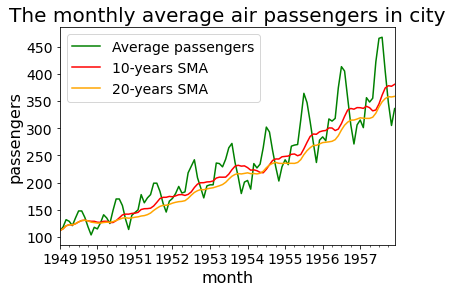

In [127]:
# Simple Moving Average
data_train_ma = data_train.copy()
data_train_ma['SMA_10'] = data_train_ma['#Passengers'].rolling(10, min_periods = 1).mean()
data_train_ma['SMA_20'] = data_train_ma['#Passengers'].rolling(20, min_periods = 1).mean()
colors = ['green', 'red', 'orange']
data_train_ma.plot(color = colors)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(labels =['Average passengers', '10-years SMA', '20-years SMA'], fontsize=14)
plt.title('The monthly average air passengers in city', fontsize=20)
plt.xlabel('month', fontsize=16)
plt.ylabel('passengers', fontsize=16)

### Predict by moving average
Phương pháp này được sử dụng khi nhu cầu sản phẩm không tăng hoặc giảm quá nhanh và không có sự thay đổi theo mùa

In [128]:
y_hat_avg = data_test.copy()
from sklearn.metrics import mean_squared_error
from math import sqrt 
def predict_value(df_train, df_test, n):
    df_test['moving_avg_forecast'] = df_train.rolling(n).mean().iloc[-1]
    #average of last n observation 
    return df_test['moving_avg_forecast']
#average of last 10 observations
def visulization_moving_average(df_train, df_test, df_predict):
    plt.figure(figsize = (15,5))
    plt.plot(df_train, label='Train')
    plt.plot(df_test, label = 'Test')
    plt.plot(df_predict, label = 'Moving Average Forecast using 10 observations')
    plt.legend(loc = 'best')
    plt.show()
    
def calculate_rms(df_test, df_predict):
    rmse = sqrt(mean_squared_error(df_test, df_predict))
    return rmse 

In [129]:
a = predict_value(data_train['#Passengers'], data_test, 10)

In [130]:
a_rmse = calculate_rms(data_test['#Passengers'], a)
a_rmse

91.77312000556347

In [131]:
b = predict_value(data_train_difference['Passengers_diff'], data_test_difference, 10)
b_rmse = calculate_rms(data_test_difference['Passengers_diff'], b)
b_rmse

50.235832718179246

In [132]:
c = predict_value(data_train_log['#Passengers_log_diff'], data_test_log, 10)
c_rmse = calculate_rms(data_test_log['#Passengers_log_diff'], c)
c_rmse

0.11264396736834036

#### Cumulative Moving Average (CMA)

Text(0, 0.5, 'passengers')

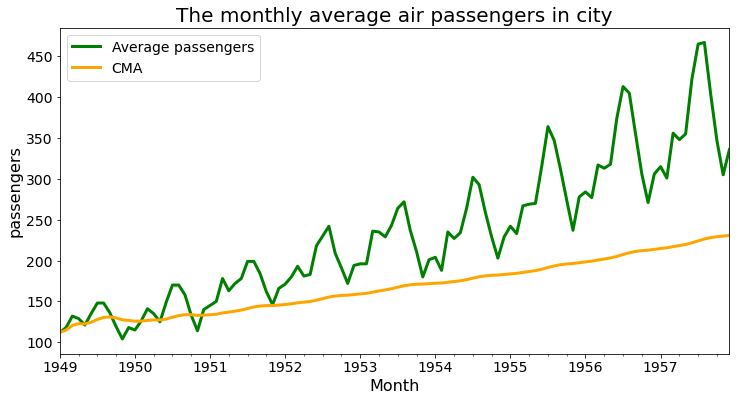

In [133]:
data_train_cma = data_train.copy()
data_train_cma['CMA'] = data_train_cma['#Passengers'].expanding().mean()
colors = ['green', 'orange']
# line plot
data_train_cma[['#Passengers', 'CMA']].plot(color=colors, linewidth=3, figsize=(12,6))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(labels =['Average passengers', 'CMA'], fontsize=14)
plt.title('The monthly average air passengers in city', fontsize=20)
plt.xlabel('Month', fontsize=16)
plt.ylabel('passengers', fontsize=16)


#### Exponential Moving Average (EMA)


In [134]:
#smoothing factor -0.1
data_train_ema = data_train.copy()
data_train_ema['EMA_0.1'] = data_train_ema['#Passengers'].ewm(alpha=0.1, adjust = False).mean()
data_train_ema['EMA_0.3'] = data_train_ema['#Passengers'].ewm(alpha=0.3, adjust = False).mean()

Text(0, 0.5, 'passengers')

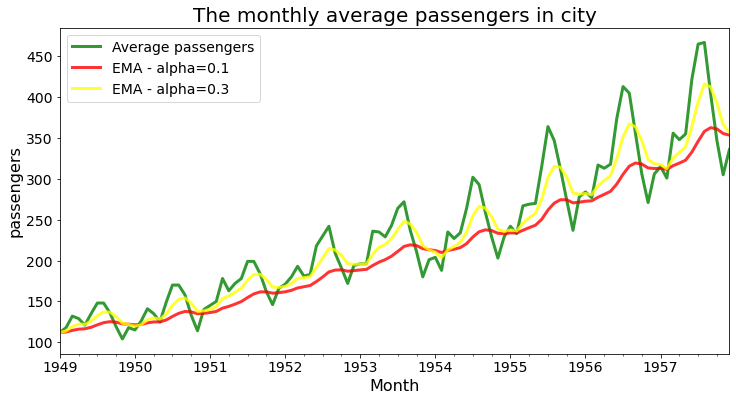

In [135]:
colors = ['green', 'red', 'yellow']
data_train_ema[['#Passengers', 'EMA_0.1', 'EMA_0.3']].plot(color=colors, linewidth=3, figsize=(12,6), alpha=0.8)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(labels=['Average passengers', 'EMA - alpha=0.1', 'EMA - alpha=0.3'], fontsize=14)
plt.title('The monthly average passengers in city', fontsize=20)
plt.xlabel('Month', fontsize=16)
plt.ylabel('passengers', fontsize=16)

### Modeling Techniques

## 1. Exponential Smoothing

### 1.1. Simple Exponential Smoothing
Phương pháp dự đoán dùng cho dữ liệu ổn định, không thay đổi nhiều, không có xu hướng, không theo mùa

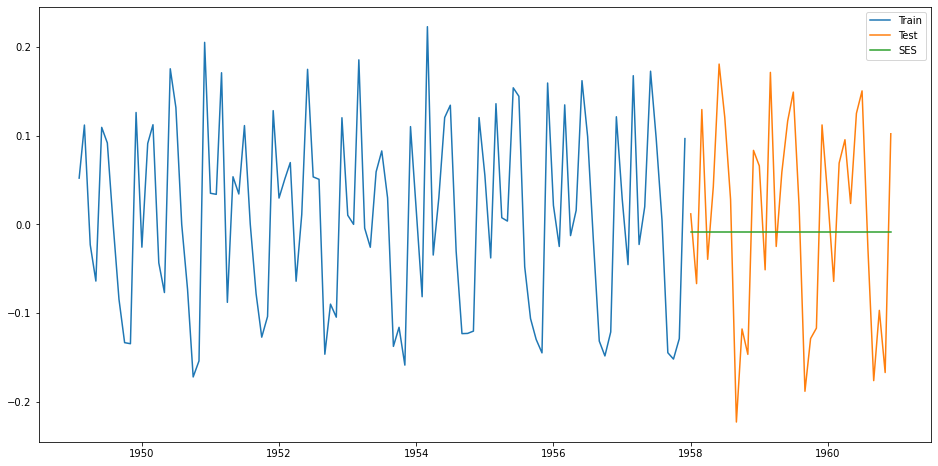

In [137]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
y_hat_avg = data_test_log.copy()
fit2 = SimpleExpSmoothing(np.asarray(data_train_log['#Passengers_log_diff'])).fit(smoothing_level = 0.5, optimized = False)
y_hat_avg['SES'] = fit2.forecast(len(y_hat_avg))
plt.figure(figsize=(16,8))
plt.plot(data_train_log['#Passengers_log_diff'], label = 'Train')
plt.plot(y_hat_avg['#Passengers_log_diff'], label = 'Test')
plt.plot(y_hat_avg['SES'], label = 'SES')
plt.legend(loc='best')
plt.show()

In [138]:
rms = sqrt(mean_squared_error(y_hat_avg['#Passengers_log_diff'], y_hat_avg['SES']))
rms

0.11366431868305131

### 1.2. Holt's Linear Trend Model. 
This method takes into account the trend of the dataset

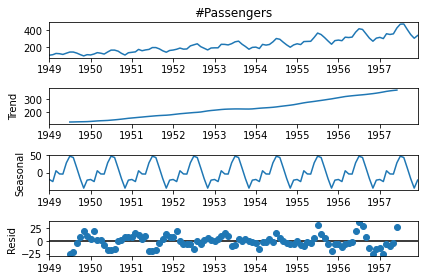

In [139]:
import statsmodels.api as sm
sm.tsa.seasonal_decompose(data_train['#Passengers']).plot()
result = sm.tsa.stattools.adfuller(data_train['#Passengers'])
plt.show()

An increasing trend can be seen in the dataset, so we will make a model base on the trend (dataset is used in this case is dataset before transform)

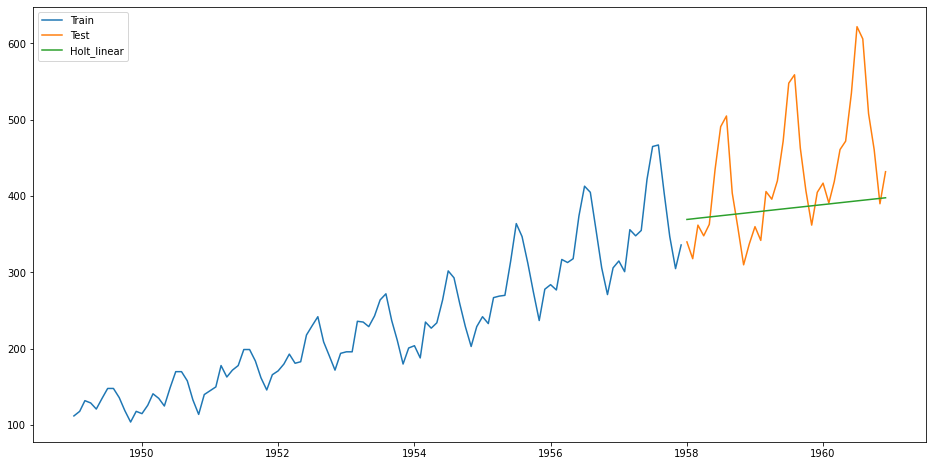

In [140]:
y_hat_avg = data_test.copy()
fit1 = Holt(np.asarray(data_train['#Passengers'])).fit(smoothing_level = 0.3, smoothing_slope = 0.1)
y_hat_avg['Holt_linear'] = fit1.forecast(len(y_hat_avg))
plt.figure(figsize=(16,8))
plt.plot(data_train['#Passengers'], label = 'Train')
plt.plot(y_hat_avg['#Passengers'], label = 'Test')
plt.plot(y_hat_avg['Holt_linear'], label = 'Holt_linear')
plt.legend(loc='best')
plt.show()

In [141]:
rms = sqrt(mean_squared_error(y_hat_avg['#Passengers'], y_hat_avg['Holt_linear']))
rms

86.66009321103597

Let see what happen if we build the model base on the stationarity dataset

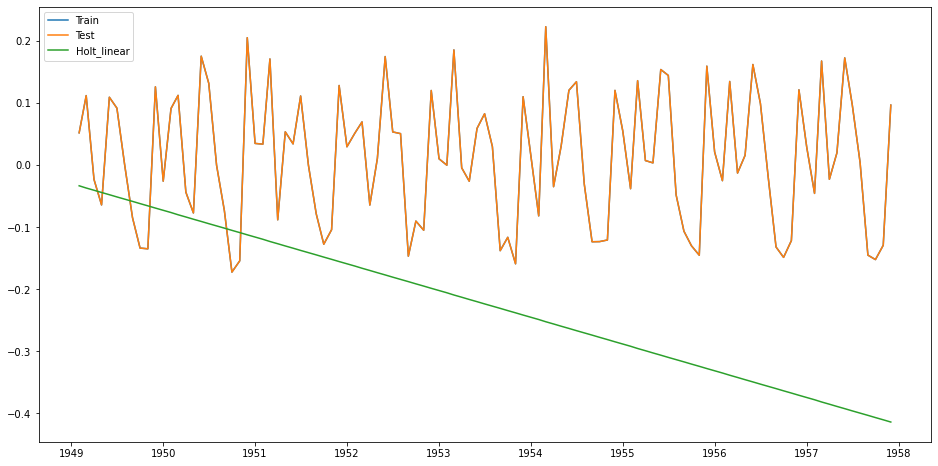

In [148]:
y_hat_avg = data_train_log.copy()
fit1 = Holt(np.asarray(data_train_log['#Passengers_log_diff'])).fit(smoothing_level = 0.3, smoothing_slope = 0.1)
y_hat_avg['Holt_linear'] = fit1.forecast(len(y_hat_avg))
plt.figure(figsize=(16,8))
plt.plot(data_train_log['#Passengers_log_diff'], label = 'Train')
plt.plot(y_hat_avg['#Passengers_log_diff'], label = 'Test')
plt.plot(y_hat_avg['Holt_linear'], label = 'Holt_linear')
plt.legend(loc='best')
plt.show()

In [149]:
rms = sqrt(mean_squared_error(y_hat_avg['#Passengers_log_diff'], y_hat_avg['Holt_linear']))
rms

0.2774380588140447

## 2. ARIMA MODEL

ARIMA stands for Auto Regression Integrated Moving Average. It is specified by three ordered parameters (p,d,q) <br>
- p: the order of the autoregressive model (number of time lags)
- d: the degree of differencing (number of times the data have had past values subtracted)
- q: the order of moving average model. 

In [155]:
##Data after apply log transformation
new_data_train = data['#Passengers_log']['1949-01-01':'1957-12-01'].to_frame()
new_data_test = data['#Passengers_log']['1958-01-01': '1960-12-01'].to_frame()

In [156]:
new_data_train.head()

,#Passengers_log
Month,
1949-01-01,4.718499
1949-02-01,4.770685
1949-03-01,4.882802
1949-04-01,4.859812
1949-05-01,4.795791


### Removing Seasonality

In [166]:
from statsmodels.tsa.seasonal import seasonal_decompose
def remove_seasonality(series):
    decomposition = seasonal_decompose(series.values, period = 24)
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    return trend, seasonal, residual
def visualize(series, trend, seasonal, residual):
    plt.subplot(411)
    plt.plot(series, label = 'Original')
    plt.legend(loc = 'best')
    plt.subplot(412)
    plt.plot(trend, label = 'Trend')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal, label = 'seasonal')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label = 'residual')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

In [167]:
trend, seasonal, residual = remove_seasonality(new_data_train['#Passengers_log'])

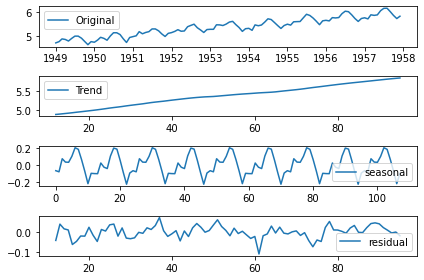

In [168]:
visualize(new_data_train['#Passengers_log'], trend, seasonal, residual)

In [169]:
def data_final(residual, series):
    train_log_decompose = pd.DataFrame(residual)
    train_log_decompose['date'] = series.index
    train_log_decompose.set_index('date', inplace = True)
    train_log_decompose.dropna(inplace = True)
    return train_log_decompose
train_log_decompose = data_final(residual, new_data_train['#Passengers_log'])
adf_test(train_log_decompose[0])

Test Statistic                -5.936098e+00
p-value                        2.319046e-07
#Lags Used                     0.000000e+00
Number of Observations Used    8.300000e+01
Critical Value (1%)           -3.511712e+00
Critical Value (5%)           -2.897048e+00
Critical Value (10%)          -2.585713e+00
dtype: float64


It can be interpreted from the results that residuals are stationary
Now we will forecast the time series using different models

In [170]:
##Data after apply log transformation and differencing 
new_data_train_diff = data['#Passengers_log_diff']['1949-01-01':'1957-12-01'].to_frame().dropna()
new_data_test_diff = data['#Passengers_log_diff']['1958-01-01': '1960-12-01'].to_frame()

In [171]:
trend, seasonal, residual = remove_seasonality(new_data_train_diff['#Passengers_log_diff'])

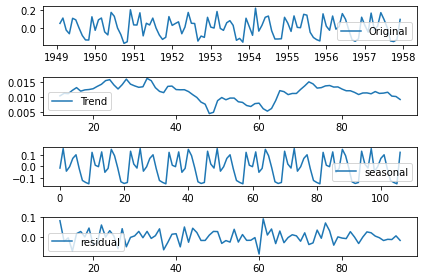

In [172]:
visualize(new_data_train_diff['#Passengers_log_diff'],trend, seasonal, residual)

In [173]:
train_log_decompose = data_final(residual, new_data_train_diff['#Passengers_log_diff'])
adf_test(train_log_decompose[0])

Test Statistic                -1.251470e+01
p-value                        2.627140e-23
#Lags Used                     0.000000e+00
Number of Observations Used    8.200000e+01
Critical Value (1%)           -3.512738e+00
Critical Value (5%)           -2.897490e+00
Critical Value (10%)          -2.585949e+00
dtype: float64


### Forecasting the time series using ARIMA

Mô hình ARIMA: Dựa trên giả thuyết chuỗi dừng và phương sai sai số không đổi. Mô hình sử dụng đầu vào chính là những tín hiệu quá khứ của chuỗi được dự báo để dự báo nó. (Thực tế các chuỗi có xu hướng tăng giảm theo thời gian, do đó yếu tố chuỗi dừng thường không đạt được, trong trường hợp chuỗi không dừng thì sẽ cần biến đổi sang chuỗi dừng bằng sai phân).<br>
ARIMA model viết tắt của cụm từ Autoregressive Intergrated Moving Average. Mô hình biểu diễn phương trình hồi qui tuyến tính đa biến (multiple linear regression) của các biến đầu vào.Gồm 2 thành phần chính:
##### 1. Auto regression:
Đây là thành phần tự hồi quy bao gồm tập hợp các độ trễ của biến hiện tại. Độ trễ bậc p chính là giá trị lùi về quá khứ p bước thời gian của chuỗi. 
##### 2. Moving average 
Quá trình dịch chuyển hoặc thay đổi giá trị trung bình của chuỗi theo thời gian.
##### 3. Integrated: Quá trình đồng tích hợp hoặc lấy sai phân. 
Yêu cầu chung của các thuật toán trong time series là chuỗi phải đảm bảo tính dừng. Hầu hết các chuỗi đều tăng hoặc giảm theo thời gian. Do đó yếu tố tương quan giữa chúng chưa chắc là thực sự mà là do chúng cùng tương quan theo thời gian. Khi biến đổi sang chuỗi dừng, các nhân tố ảnh hưởng thời gian được loại bỏ và chuỗi sẽ dễ dự báo hơn. Để tạo thành chuỗi dừng, một phương pháp đơn giản nhất là chúng ta sẽ lấy sai phân. Một số chuỗi tài chính còn qui đổi sang logarit hoặc lợi suất. Bậc của sai phân để tạo thành chuỗi dừng còn gọi là bậc của quá trình đồng tích hợp (order of intergration).
- First of all we will fit the ARIMA model on our time series for that we have to find the optimized values for the p,d,q parameters
- To find the optimized values of these parameters, we will use ACF (Autocorrelation Function) and PACF(Partial Autocorrelation Function)
    - ACF: is a measure of the correlation between the TimeSeries with a lagged version of itself
    - PACF: measures the correlation between the TimeSeries with a lagged version of itself but after eliminating the variations already explained by the intervening comparisions

### Lựa chọn tham số ARIMA(p,d,q)
1. Tự tương quan (ACF) 
Hầu hết các chuỗi thời gian sẽ có sự tương quan với giá trị trễ của nó và các giá trị càng gần nhau thì tương quan càng mạnh hoặc các giá trị cùng thuộc 1 chu kì của chuỗi thì sẽ có tương quan cao (chẳng hạn như cùng tháng trong chu kì năm hay cùng quí trong chu kì năm). 
2. 

In [174]:
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(new_data_train_diff, nlags = 25)
lag_pacf = pacf(new_data_train_diff, nlags = 25, method = 'ols')

ACF and PACF plot

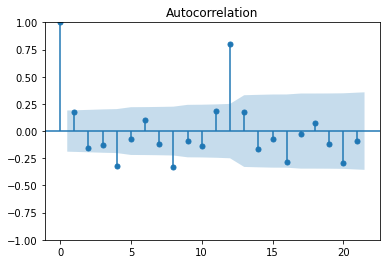

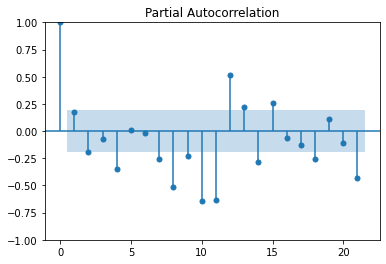

In [177]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
acf = plot_acf(new_data_train_diff)
pacf = plot_pacf(new_data_train_diff)

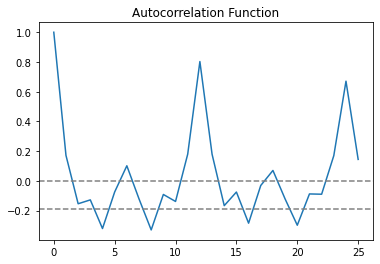

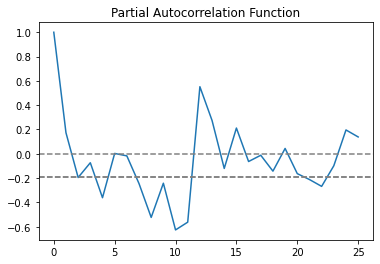

In [132]:
plt.plot(lag_acf)
plt.axhline(y=0, linestyle = '--', color = 'gray')
plt.axhline(y=-1.96/np.sqrt(len(new_data_train_diff)), linestyle ='--', color = 'gray')
plt.title('Autocorrelation Function')
plt.show()
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle = '--', color = 'gray')
plt.axhline(y=-1.96/np.sqrt(len(new_data_train_diff)), linestyle = '--', color ='gray')
plt.axhline(y=-1.96/np.sqrt(len(new_data_train_diff)),linestyle = '--', color ='gray')
plt.title('Partial Autocorrelation Function')
plt.show()

p value is the lag value where the PACF chart crosses the upper confidence interval for the first time. It can be noticed that in this case p=2 <br>
q value is the lag value where the ACF chart crosses the upper confidence interval for the first time. It can be noticed that in this case q=2 <br>
Now we will make the ARIMA models as we have the p,q values. We will make the AR and MA model sepeartely and then combine them together

In [133]:
from statsmodels.tsa.ar_model import AutoReg
model = AutoReg(new_data_train_diff, lags = 20)
model_fit = model.fit()
predictions = model_fit.predict(start = len(new_data_train_diff), end = len(new_data_train_diff) + len(new_data_test_diff) -1, dynamic = False)
rmse = sqrt(mean_squared_error(new_data_test_diff, predictions))
rmse

0.04526889658609488

In [139]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(new_data_train_diff, order = (2,0,2))
results_fit = model.fit()
results_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:     #Passengers_log_diff   No. Observations:                  107
Model:                   ARIMA(2, 0, 2)   Log Likelihood                 105.982
Date:                  Fri, 23 Jun 2023   AIC                           -199.964
Time:                          21:05:01   BIC                           -183.927
Sample:                      02-01-1949   HQIC                          -193.463
                           - 12-01-1957                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0110      0.001     11.630      0.000       0.009       0.013
ar.L1          0.4005      0.188      2.135      0.033       0.033       0.768
ar.L2          0.0279      0.187      0.149      0.881      -0.339       0.395
ma.L1         -0.3979      0.234     -1.702      0.089      -0.856       0.060
ma.L2         -0.5814      0.222     -2.622      0.009      -1.016      -0.147
sigma2         0.0077      0.002      3.442      0.001       0.003       0.012
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 6.19
Prob(Q):                              0.90   Prob(JB):                         0.05
Heteroskedasticity (H):               0.99   Skew:                            -0.08
Prob(H) (two-sided):                  0.97   Kurtosis:                         1.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""